# Misdiagnoses Network Generation and Analysis

## 0. Preamble

This notebook is meant to generate, vizualize, and analyze a misdiagnosis network for the final project of Social Graphs and Analysis 2022 at DTU.

In [1]:
# Import the required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from fa2 import ForceAtlas2
from community import community_louvain
import requests
import urllib
import pickle
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
import regex as re
import nltk
nltk.download('punkt')
from scipy import stats
import powerlaw
from wordcloud import WordCloud


/Users/petermehler/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/petermehler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Load the network


In [2]:
''' useful functions in network creation '''

def identify_duplicate_nodes(G):
    ''' Find duplicate nodes '''
    # Find those node names that are similar with the pairwise scoring of levenstein distance
    nodes_ = list(G.nodes())
    d={}
    for i in range(len(nodes_)):
        d[nodes_[i]]=[]
        for j in range(i,len(nodes_)):
            # check if pair is close in edit distance
            if nodes_[i] != nodes_[j] and fuzz.ratio(nodes_[i],nodes_[j])>90:
                d[nodes_[i]].append(nodes_[j])
    
    return d

def merge_duplicate_chains(d):
    '''
    Merge chains of duplicates
    e.g. 1 --> 2, 2 --> 3 ----> 1 --> [2,3]
    input : dictionary of {node:duplicate_list}
    output : cleaned dictionary of merged chains
    '''
    keys = list(d.keys())
    cleaned_d = {}
    for k,v in d.items():
        if len(v)>0:
            cleaned_d[k] = v
            for i in v:
                if i and i in keys and d[i]:
                    # we want to add this value to k
                    cleaned_d[k] += d[i]

    return cleaned_d

def merge_nodes(G):
    '''
    Identify and merge duplicate nodes
    input: directed graph G
    output: G (with nodes merged), and a dictionary of merged nodes merged_to:merged
    '''
    d = identify_duplicate_nodes(G)
    cleaned_d = merge_duplicate_chains(d)
    G_temp = G.copy()
    merged={}
    for k,v in cleaned_d.items():
        # check that we actually want to merge these
        if len(v)>0 and not any(substring in k for substring in dont_change):
            i=0
            while i<len(v):
                try:
                    # contract the nodes we want to merge
                    G_temp = nx.contracted_nodes(G_temp, k, v[i], self_loops=False)
                    merged[v[i]]=k
                except:
                    pass
            i+=1

    return G_temp, merged

def save_weak_comp(G):
    '''
    Find the biggest weakly connected component and create a new network from this (G)
    '''
    largest_cc = max(nx.weakly_connected_components(G), key=len)
    G0 = G.subgraph(largest_cc)
    nx.write_edgelist(G0, 'WCC_misdiagnosis_network_merged_dups.edgelist')

def scrape_misdiagnoses(soup_web):
    '''
    Given the beautiful soup object, scrape misdiagnosis relationships and text descriptions 
    '''
    # Find the diseases in mymisdiagnosis webpage, their misdiagnoses and the corresponding text
    diseases_names = set() # disease name
    diseases_edges = set() # disease, misdiagnose pairs
    disease_text_dict = dict() # disease description text

    for link_disease in list(set(soup_web.find_all('a'))): # find all the links in mymisdiagnosis.com

        link_disease = link_disease.get('href') # get the url
        if 'diagnosis/' in link_disease: # check that it is one of the diseases
            disease_name = link_disease[10:]
            diseases_names.add(disease_name)
            
            # Look through the page of that disease to find the pages of the misdiagnoses (A)
            # In every misdiagnoses, we will find the text in and store it in the disease_text_dict (B)
            disease_text_dict[disease_name] = []

            # Look for the misdiagnoses in the disease page (A)
            url_disease = "https://www.mymisdiagnosis.com/"+str(link_disease)
            result_disease = requests.get(url_disease, headers=headers)
            soup_disease = BeautifulSoup(result_disease.content.decode(), 'html.parser')

            # Repeat the process, to find all the links within the disease's page
            for link_misdiagnosis in list(set(soup_disease.find_all('a'))):

                link_misdiagnosis = link_misdiagnosis.get('href')
                if 'misdiagnosis/' in link_misdiagnosis: # check that it is one of the misdiagnosis
                    misdiagnosis_name =  link_misdiagnosis.split('/')[2]
                    diseases_edges.add((disease_name, misdiagnosis_name)) # add the link to the edges
                    
                    # Look into the disease-misdiagnosis page and store the info (B)
                    url_misdiagnosis = "https://www.mymisdiagnosis.com/" + str(link_misdiagnosis)
                    result_misdiagnosis = requests.get(url_misdiagnosis, headers=headers)
                    soup_misdiagnosis = BeautifulSoup(result_misdiagnosis.content.decode(), 'html.parser')
                    
                    # Find the main text within the disease-misdiagnosis page
                    main_text = soup_misdiagnosis.find_all("div",class_= "record_main_body")
                    disease_text_dict[disease_name].append(main_text[0].text)
            
    diseases_names = list(diseases_names)

    return diseases_edges, diseases_names, disease_text_dict

The first step is to load the network, which we name *The Misdiagnosis Network*. The nodes are the diseases and we place a link from disease $A$ to disease $B$ if disease $A$ is misdiagnosed as diasease $B$.

We created *The Misdiagnosis Network* by scraping [MyMisdiagnosis](https://www.mymisdiagnosis.com/diagnosis) webpage.

Since it takes at least 30 minutes to create the network from scratch, we already did it for you :) Together with this notebook we provided the network. Therefore, you can directly load the network running the next cell (make sure that variable `network_exists` is set to `True` ).

However, if you had problems downloading the files or you just prefer to create the network from scratch you just need to change value of `network_exists` variable to `False` and run the next cell. 

In [3]:
network_exists = True

if network_exists:

    ''' Load the network '''
    
    # Load the network (note: the network G is only the weakly connected component)
    G = nx.read_edgelist(
    'WCC_misdiagnosis_network_merged_dups.edgelist', create_using=nx.DiGraph)
    disease_text_dict = pickle.load(open(r"nlp_dict.data", "rb"))
    diseases245 = list(disease_text_dict.keys())

else:
    ''' Create the network '''

    # Replace with your User Agent (inspect element on the url below, and find User-Agent in network)
    headers = config['User-Agent']

    # Read the mymisdiagnosis webpage
    url_web = "https://www.mymisdiagnosis.com/diagnosis"
    result_web = requests.get(url_web, headers=headers)
    soup_web = BeautifulSoup(result_web.content.decode(), 'html.parser')

    # Generate edges from beautiful soup object
    diseases_edges, diseases_names, disease_text_dict = scrape_misdiagnoses(soup_web)
    diseases245 = list(disease_text_dict.keys())
    G_diseases = nx.diGraph()
    G_diseases.add_edges_from(diseases_edges)

    # Merge near duplicates using leventstein distance
    G, merged_nodes = merge_nodes(G)
    
    ''' Save the network '''
    name = 'WCC_misdiagnosis_network_merged_dups.edgelist'
    save_weak_comp(G, name)
    

## 2. Analyze and visualize the network

In this section, we analyze network statistics and we visualize the network by using `NetworkX`.

In [4]:
# Check that G is a directed graph
print(f'Is G a directed graph? {nx.is_directed(G)}')

Is G a directed graph? True


In [5]:
''' basic degree statistics '''

# Basic degree statistics are written in 'network_degrees.txt' file
networkStatsFile = 'network-degrees-stats.txt'
networkStats = open(networkStatsFile, 'w')

# Save the number of nodes in G
n_nodes = G.number_of_nodes()
# Save the number of edges in G
n_edges = G.number_of_edges()

networkStats.write('number of nodes: ' + str(n_nodes) + '\nnumber of edges: ' + str(n_edges) + '\n\n')

# Create an array with the out-degree centralities
values_out_degree_centrality = np.array(list(nx.out_degree_centrality(G).values()))
# Create an array with the in-degree centralities
values_in_degree_centrality = np.array(list(nx.in_degree_centrality(G).values()))

networkStats.write('avg out-degree-dentrality: ' + str(np.mean(values_out_degree_centrality)) + '\navg in-degree-dentrality: ' + str(np.mean(values_in_degree_centrality)) + '\n\n')

# Create an array with the in-degrees
values_in_degree = np.array([value[1] for value in G.in_degree()])
# Create an array with the out-degrees
values_out_degree = np.array([value[1] for value in G.out_degree()])

networkStats.write('avg out-degree: ' + str(np.mean(values_out_degree)) + '\navg in-degree: ' + str(np.mean(values_in_degree)) + '\n\n')
networkStats.write('median out-degree: ' + str(np.median(values_out_degree)) + '\nmedian in-degree: ' + str(np.median(values_in_degree)) + '\n\n')
networkStats.write('min out-degree: ' + str(np.min(values_out_degree)) + '\nmin in-degree: ' + str(np.min(values_in_degree)) + '\n\n')
networkStats.write('max out-degree: ' + str(np.max(values_out_degree)) + '\nmax in-degree: ' + str(np.max(values_in_degree)) + '\n\n')

networkStats.close()

# Print the basic degree statistics
print('number of nodes: ' + str(n_nodes) + '\nnumber of edges: ' + str(n_edges) + '\n')
print('avg out-degree-dentrality: ' + str(np.mean(values_out_degree_centrality)) + '\navg in-degree-dentrality: ' + str(np.mean(values_in_degree_centrality)) + '\n')
print('avg out-degree: ' + str(np.mean(values_out_degree)) + '\navg in-degree: ' + str(np.mean(values_in_degree)) + '\n')
print('median out-degree: ' + str(np.median(values_out_degree)) + '\nmedian in-degree: ' + str(np.median(values_in_degree)) + '\n')
print('min out-degree: ' + str(np.min(values_out_degree)) + '\nmin in-degree: ' + str(np.min(values_in_degree)) + '\n')
print('max out-degree: ' + str(np.max(values_out_degree)) + '\nmax in-degree: ' + str(np.max(values_in_degree)))


number of nodes: 901
number of edges: 1297

avg out-degree-dentrality: 0.001599457393020101
avg in-degree-dentrality: 0.0015994573930201011

avg out-degree: 1.439511653718091
avg in-degree: 1.439511653718091

median out-degree: 0.0
median in-degree: 1.0

min out-degree: 0
min in-degree: 0

max out-degree: 23
max in-degree: 13


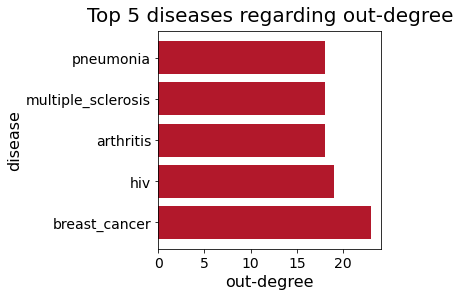

In [6]:
# Save / Display the top i diaseases regarding out-degree

i = 5
fig = plt.figure(figsize=(4, 4))
out_degs = sorted(G.out_degree, key=lambda x: x[1], reverse=True)[:i]
plt.barh([x[0] for x in out_degs], [x[1] for x in out_degs], color='#b2182b')
plt.title(f'Top {i} diseases regarding out-degree', fontsize=20, pad=10)
plt.xlabel('out-degree', labelpad=4, fontsize=16)
plt.ylabel('disease', labelpad=4, fontsize=16)
plt.xticks(fontsize=14, alpha=1)
plt.yticks(fontsize=14, alpha=1)
plt.savefig(f'top-{i}_out-degree', dpi=300, bbox_inches='tight')

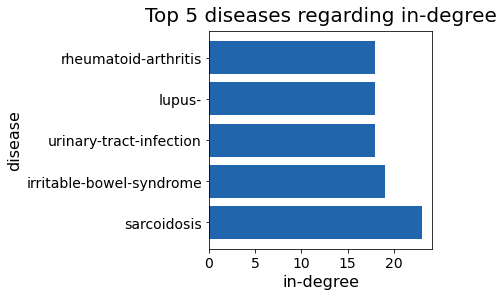

In [7]:
# Save / Display the top i diaseases regarding in-degree

i = 5
fig = plt.figure(figsize=(4, 4))
in_degs = sorted(G.in_degree, key=lambda x: x[1], reverse=True)[:i]
plt.barh([x[0] for x in in_degs], [x[1] for x in out_degs], color='#2166ac')
plt.title(f'Top {i} diseases regarding in-degree', fontsize=20, pad=10)
plt.xlabel('in-degree', labelpad=4, fontsize=16)
plt.ylabel('disease', labelpad=4, fontsize=16)
plt.xticks(fontsize=14, alpha=1)
plt.yticks(fontsize=14, alpha=1)
plt.savefig(f'top-{i}_in-degree', dpi=300, bbox_inches='tight')

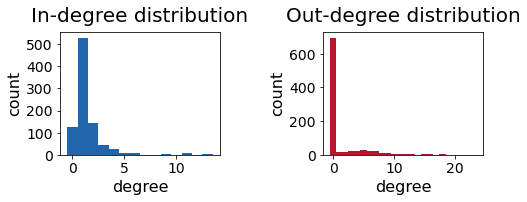

In [8]:
''' degree distribution (linear) '''

fig = plt.figure(figsize=(8, 4))

# Create in-going degree distribution
bins_in = [x-0.5 for x in range(np.min(values_in_degree), np.max(values_in_degree)+2)]

plt.subplot(1, 2, 1)
plt.hist(values_in_degree, bins=bins_in, color='#2166ac')
plt.title('In-degree distribution', fontsize=20, pad=10)
plt.xlabel('degree', labelpad=4, fontsize=16)
plt.ylabel('count', labelpad=4, fontsize=16)
plt.xticks(fontsize=14, alpha=1)
plt.yticks(fontsize=14, alpha=1)

# Create out-going degree distribution
bins_out = [x-0.5 for x in range(np.min(values_out_degree), np.max(values_out_degree)+2)]

plt.subplot(1, 2, 2)
plt.hist(values_out_degree, bins=bins_out, color='#b2182b')
plt.title('Out-degree distribution', fontsize=20, pad=10)
plt.xlabel('degree', labelpad=4, fontsize=16)
plt.ylabel('count', labelpad=4, fontsize=16)
plt.xticks(fontsize=14, alpha=1)
plt.yticks(fontsize=14, alpha=1)

fig.tight_layout(pad=5.0)
plt.savefig('degree1.png', dpi=300)

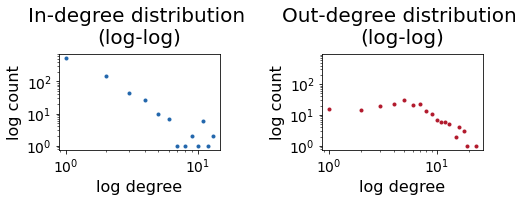

In [9]:
''' degree distribution (log-log) '''

fig = plt.figure(figsize=(8, 4))

# Create in-going degree distribution (log-log)
hist_in, bins_in = np.histogram(values_in_degree, bins=bins_in)

plt.subplot(1, 2, 1)
plt.loglog(range(np.min(values_in_degree), np.max(values_in_degree)+1), hist_in, '.', color='#2166ac')
# fit = powerlaw.Fit(values_in_degree) 
# fit.power_law.plot_pdf(color='g', linestyle='--')
plt.title('In-degree distribution \n(log-log)', fontsize=20, pad=10)
plt.xlabel('log degree', labelpad=4, fontsize=16)
plt.ylabel('log count', labelpad=4, fontsize=16)
plt.xticks(fontsize=14, alpha=1)
plt.yticks(fontsize=14, alpha=1)

# Create out-going degree distribution (log-log)
hist_out, bins_out = np.histogram(values_out_degree, bins=bins_out)

plt.subplot(1, 2, 2)
plt.loglog(range(np.min(values_out_degree), np.max(values_out_degree) + 1), hist_out, '.', color='#b2182b')
# fit = powerlaw.Fit(values_out_degree) 
# fit.power_law.plot_pdf(color='g', linestyle='--')
plt.title('Out-degree distribution \n(log-log)', fontsize=20, pad=10)
plt.xlabel('log degree', labelpad=4, fontsize=16)
plt.ylabel('log count', labelpad=4, fontsize=16)
plt.xticks(fontsize=14, alpha=1)
plt.yticks(fontsize=14, alpha=1)

fig.tight_layout(pad=5.0)
plt.savefig('degree2.png', dpi=300)

In [10]:
''' scale-free property of the network '''

# Estimate the slope of the incoming degree distributions

alpha_in = powerlaw.Fit(values_in_degree).alpha
alpha_out = powerlaw.Fit(values_out_degree).alpha

print('alpha_in = ', alpha_in)
print('alpha_out = ', alpha_out)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
alpha_in =  3.932381753431755
alpha_out =  4.128540207335318


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


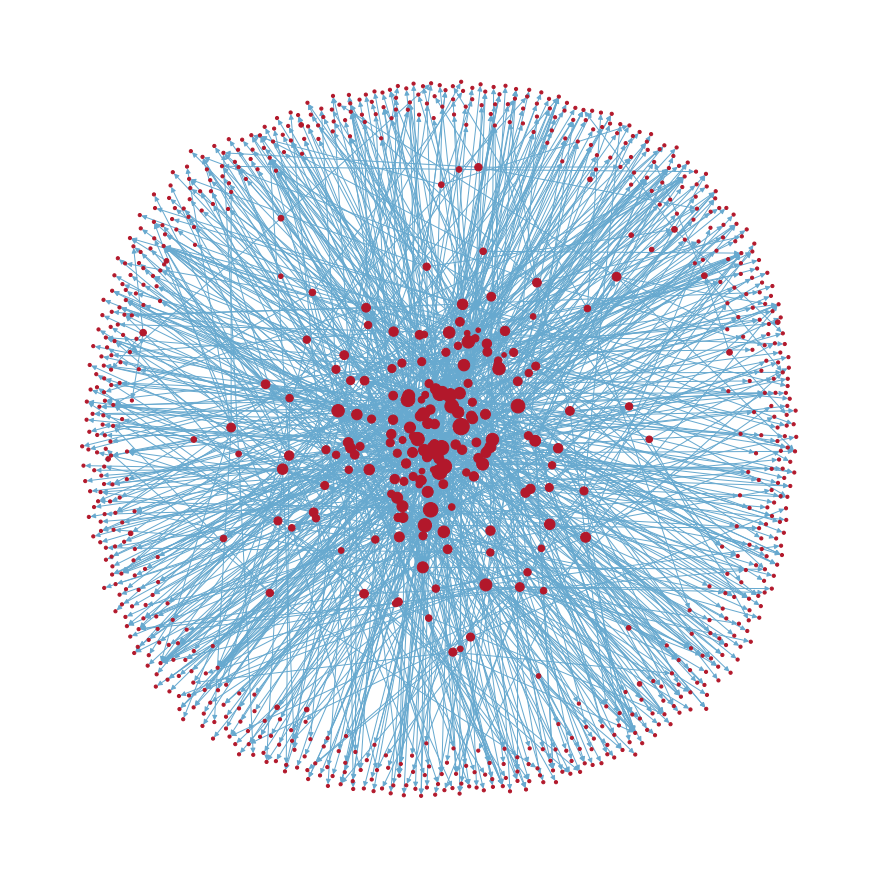

In [11]:
''' network visualization using NetworkX '''

pos = nx.spring_layout(G)
fig = plt.figure(3, figsize=(12,12))

nx.draw(G,pos, width=1, node_color='#b2182b', edge_color='#67a9cf', with_labels=False, node_size=[v * 10000 + 10 for v in nx.out_degree_centrality(G).values()], font_size=8, edge_cmap=plt.cm.get_cmap('Purples'))

fig.set_facecolor('#FFFFFF')

# Save the network figure
plt.savefig('network_visualization', dpi=300)
plt.show()

## 3. Analyze medical specialty

In this section we analyze misdiagnosis relationship between diseases regarding specialty.

In [12]:
''' add specialty attribute to the nodes '''

# Read annotated specialties for diseases
# Note: specialties_df is a pandas dataframe that contains the primary and second specialties for 1784 diseases
specialties_df = pd.read_csv('diseases_types.txt', '\t',encoding = 'unicode_escape')

# Create a dictionary of the form --> {disease: specialty})
specialties_map = specialties_df[['disease','specialty 1','specialty 2']].set_index('disease').to_dict()

# Add attributes to the nodes
for s in zip(specialties_map['specialty 2'].items(), specialties_map['specialty 1'].items()):
    s1 = s[1][1]
    s2 = s[0][1]
    nx.set_node_attributes(G, {s[0][0]: {'specialty':[s1,s2]}})

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_33901/279383913.py:5: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  specialties_df = pd.read_csv('diseases_types.txt', '\t',encoding = 'unicode_escape')


In [13]:
# Display specialties and the number of diseases belonging to each of the specialties
specialties_df.groupby('specialty 1')['disease'].nunique()

specialty 1
GP / pediatry         18
allergology            5
cardiology            16
dentist                5
dermatology           45
endocrinology         18
endodontics            4
gastroenterology      62
gynecology            35
hematology            20
hepatology            15
infectious disease    27
internal medicine      5
nephrology             4
neurology             39
neurosurgery           2
oncology              13
ophtalmology           2
orthopedy              7
otolaryngology        20
psychiatry            20
pulmonology           15
rheumatology          33
surgery                2
urology               14
Name: disease, dtype: int64

In [14]:
# Display the number of specialties
print('number of specialties = ', specialties_df.groupby('specialty 1')['disease'].nunique().size)

number of specialties =  25


In [15]:
''' analyze diseases regarding specialty '''

# Disease specialty statistics are written in 'disease-specialties-stats.txt' file
specilatyStatsFile = 'disease-specialty-stats.txt'
specialtyStats = open(specilatyStatsFile, 'w')

specialtyStats.write('----\n')
specialtyStats.write('l_I: number of links between disease and dieases of same specialty\n')
specialtyStats.write('l_O: number of links between disease and diseases of different specialty\n')
specialtyStats.write('l_U: number of links between disease and unlabelled diseases\n\n')
specialtyStats.write('----\n')
specialtyStatsList = list()

specialtyStats.write('disease;specialty;l_I;l_O;l_U\n')

total_labelled = 0
total_unlabelled = 0
# Iterate on every node i of G
for i in G.nodes():
    # Check if the node has specialty attribute
    if 'specialty' in G.nodes[i].keys():
        # --> Define source_specialty as the primary specialty of disease i
        source_specialty = G.nodes[i]['specialty'][0]
        total_labelled += 1
    else:
        # --> Define source_specialty as None
        source_specialty = None
        total_unlabelled += 1

    # l_I is the number of links between diseases of source_specialty
    l_I = 0
    # l_O is the number of links between diseases of source_specialty and diseases of outside source_specialty
    l_O = 0
    # l_U is the number of links between diseases of source_specialty and unlabelled diseases
    l_U = 0

    # Iterate on neighbours of node i to calculate l_I, l_O and l_U
    for nbr in G[i]:
        # Get target specialty  of neighbours of node i
        if 'specialty' in G.nodes[nbr].keys():
            target_specialty = G.nodes[nbr]['specialty'][0]
            if target_specialty == source_specialty:
                l_I += 1
            else:
                l_O += 1
        else:
            l_U += 1

    # Save calculated scores
    specialtyStatsList.append((i, source_specialty, l_I, l_O, l_U))
    specialtyStats.write(f'{i};{source_specialty};{l_I};{l_O};{l_U}\n')

# Create dataframe that contains the statistics of specialities
specialty_stats_df = pd.DataFrame(
    specialtyStatsList, columns=['disease','specialty','l_I','l_O','l_U'])

specialty_stats_dict = specialty_stats_df['specialty'].value_counts().to_dict()

# Check
# print(total_labelled + total_unlabelled == len(G.nodes()))

specialtyStats.write('----\n')
specialtyStats.write('Number of labelled diseases: ' + str(total_labelled) + '\n')
specialtyStats.write('Number of unlabelled diseases: ' + str(total_unlabelled) + '\n\n')
specialtyStats.write('----\n')
specialtyStats.close()

In [16]:
''' analyze specialty '''

# Specialty statistics are written in 'specialties-stats.txt' file
specilatyStatsFile = 'specialty-stats.txt'
specialtyStats = open(specilatyStatsFile, 'w')

# Question: Out of all possible links, how many exist between certain types of specialties?
# Answers the question: "Is misdiagnosis more likely within or across specialties?"
link_probabilities = list()

# Number of links between diseases of same specialty
m_I_sum = 0
# Number of links between diseases of different specialties
m_O_sum = 0
# Number of links between unlabelled diseases
# --> labelled-unlabelled or unlabelled-unlabelled
m_U_sum = 0

# Count up the different types of edges for each specialty
# then divide by the number of total possible links
specialtyStats.write('----\n')
specialtyStats.write('m_I: number of links within specialty\n')
specialtyStats.write('m_O: number of links outside specialty\n')
specialtyStats.write('m_U: number of links with unlabelled diseases\n\n')

specialtyStats.write('p_I: probability of a disease of specialty having a link within specialty\n')
specialtyStats.write('p_O: probability of a disease of specialty having a link outside specialty\n')
specialtyStats.write('p_U: probability of a disease of specialty having a link with unlabelled diseases\n\n')

specialtyStats.write('----\n')
specialtyStats.write('specialty;m_I;m_O;m_U;p_I;p_O;p_U\n')

# For each speciality
for specialty, value in specialty_stats_df.groupby('specialty'):
    m_I = value['l_I'].sum()
    m_I_sum += m_I
    m_O = value['l_O'].sum()
    m_O_sum += m_O
    m_U = value['l_U'].sum()
    m_U_sum += m_U

    # n_I is the number of diseases in the same specialty
    n_I = specialty_stats_dict[specialty]
    # n_O is the number of diseases in other specialties
    n_O = abs(total_labelled - n_I)

    p_I = round(m_I / (n_I * (n_I - 1)), 4)
    p_O = round(m_O / (n_I * n_O), 4)
    p_U = round(m_U / (n_I * total_unlabelled), 4)

    link_probabilities.append((specialty, p_I, p_O, p_U, len(value)))
    specialtyStats.write(f'{specialty};{m_I};{m_O};{m_U};{p_I};{p_O};{p_U}\n')

specialtyStats.write('----\n')
specialtyStats.close()

In [17]:
# Export probability analysis to latex table

link_probabilities_df = pd.DataFrame(link_probabilities, columns=['specialty','p-in','p-out','$p-u$','count'])
link_probabilities_df = link_probabilities_df[~link_probabilities_df['p-in'].isna()]
link_probabilities_df.sort_values(by='count', ascending=False).to_latex('specialty_stats_table.tex', index=False)

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_33901/3269531382.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  link_probabilities_df.sort_values(by='count', ascending=False).to_latex('specialty_stats_table.tex', index=False)


## 4. Find communities

In [18]:
''' useful functions in this section '''

def custom_tokenize(disease_texts):
    ''' Given the texts for a disease as an input, removes punctuation from the texts, 
    merges all texts in one and returns cleaned tokens as an output '''

    tokens = list()
    disease_text = ' '.join(disease_texts)      
    disease_text = re.sub(r'\n', '', disease_text)
    disease_text = re.sub(r'[^\w\s]', ' ', disease_text)
    disease_text = disease_text.lower()
    tokens = nltk.word_tokenize(disease_text)        

    return tokens

def aggregate_community(community, text_dict):
    ''' 
    Given a community (list of disease names in a given community) as
    an input, it returns the aggregated list of tokens as an output
    '''
    diseases_with_text = 0
    tokens_list = []
    for disease in community:
        if disease in text_dict:
            tokens_list.append(custom_tokenize(text_dict[disease]))
            diseases_with_text += 1

    return tokens_list, diseases_with_text

def build_idf_dict(texts):
    '''given a group of texts (list of lists of cleaned tokens) as an input it 
    returns the inverse document frequency dictionary as an output.'''
    
    idf_dict = dict()
    count = 0
    # Build global word occurrence
    # Note: only binary for existence in document, not frequency
    for text in texts:
        for w in set(text):
            if w not in  idf_dict.keys():
                idf_dict[w] = 0
            idf_dict[w] += 1             

    for word, count in idf_dict.items():
        idf_dict[word] = np.log(len(texts) / (idf_dict[word] + 1)) + 1

    # Since we are taking the log and adding 1 in the idf dict, 
    # words that appear in all docs have a non-zero idf score
    # in order to avoid these words, we pull them to 0 before processing

    min_idf = min(idf_dict.values())
    idf_dict = {key: 0 if value==min_idf else value for key, value in idf_dict.items()}

    return idf_dict

def get_community_tfidf(community, idf_list):
    '''
    Given a community (as a list of disease names) and an IDF dictionary as an 
    input, it returns a TF-IDF dictionary with words as keys and tf-idf as values
    '''
    l = len(community)
    # Get term frequency for all words in community
    freq_dist_dict = nltk.FreqDist(community)
    # Normalize all frequencies by the length of the community
    freq_dist_normalized_dict = {key: value/l for key, value in freq_dist_dict.items()}
    # Multiply by the idf of that word
    community_tfidf_dict = {key: value * idf_list[key] for key, value in freq_dist_normalized_dict.items()}

    return community_tfidf_dict

def input_string_wordcloud(tf_idf):
    '''Given a TF-IDF as an input, it returns a long string with the words 
    repeated as many times as their score indicates as an output'''
    
    # Scale such that the min value is 1, ignore tfidf of 0
    min_v = min([v for v in tf_idf.values() if v>0])
    scaled_tf_idf = {key: value/min_v  for key, value in tf_idf.items()}

    list_string = []
    # Round to int to get whole number of words for visualization
    for word, score in scaled_tf_idf.items():
        list_string += [word] * int(np.round(score))
    
    input_string = ' '.join(list_string)
    return input_string

def create_and_plot_wordcloud(input_string, comm_number, disease_number):
    ''' Plots the wordcloud for the given community'''
    wordcloud = WordCloud(width = 1200, height = 600, 
                    background_color='white', 
                    colormap='RdBu', 
                    min_font_size = 40, 
                    collocations=False).generate(input_string)
    fig = plt.figure(figsize=(8, 4))
    plt.title(f'Wordcloud community {comm_number} (number of diseases with text = {disease_number})', fontsize=15, pad=10)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    name_fig = 'figures/WC_C' + str(comm_number) + '.svg'
    plt.savefig(name_fig)
    plt.show()

def plot_specialty_hist(G, comm_id, comm_dis, specialty_list):
    
    # Initialize histogram
    hist = np.zeros_like(specialty_list)

    # Get specialties of disease 
    specialty_dict = nx.get_node_attributes(G, 'specialty')
    
    # Loop through the diseases within the community
    for dis in comm_dis:
        
        if dis in specialty_dict:
            dis_specialty = specialty_dict[dis]
            dis_specialty = [x for x in dis_specialty if str(x) != 'nan'] # remove nan values

            # Loop through the specialties of disease
            for sp in dis_specialty:
                # Add 1 in the corresponding specialty
                hist[list(specialty_list).index(sp)] += 1
        

    fig = plt.figure(figsize=(12,4))
    #plt.bar(np.arange(len(specialty_list)), hist/np.linalg.norm(hist), color='#67a9cf')
    plt.bar(np.arange(len(specialty_list)), hist, color='#67a9cf')
    plt.title(f'Histogram of specialties for community {comm_id} (number of diseases with labeled specialty = {np.sum(hist)})', fontsize=15, pad=10)
    plt.xlabel('Specialties', labelpad=4, fontsize=16)
    plt.ylabel('Count', labelpad=4, fontsize=16)
    plt.xticks(np.arange(len(specialty_list)), specialty_list, rotation=45, ha='right', fontsize=14, alpha=1)
    plt.yticks(fontsize=14, alpha=1)
    name_fig = 'figures/H_C' + str(comm_id) + '.svg'
    plt.savefig(name_fig)

In the cell below we compute:
* `partition`: the partition of the graph nodes which maximises the modularity using the Louvain heuristices, i.e. the partition of highest modularity, i.e. the highest partition of the dendrogram generated by the Louvain algorithm.
* `modularity`: the modularity of partition of G.
* `communities`: the communities. 

In [19]:
''' Compute best partition, the modularity and the communities '''

# Consider undirected version of G
G = G.to_undirected()

# Compute the partition of the graph nodes which maximises the modularity using the Louvain algorithm
partition = community_louvain.best_partition(G)

# Compute modularity of partition of G
modularity = community_louvain.modularity(partition, G)
    
# Compute the communities
community_dict = dict()
community_dict = {key: list() for key in list(set(partition.values()))}
for disease, community_id in partition.items():
    community_dict[community_id].append(disease)

print(f'Modularity = {modularity}')
print(f'Number of communities = {len(community_dict)}')
print(f'Community sizes = {list(len(v) for v in community_dict.values())}')

Modularity = 0.80993896484375
Number of communities = 25
Community sizes = [41, 29, 16, 33, 46, 25, 9, 63, 79, 30, 54, 14, 81, 31, 37, 22, 44, 18, 13, 52, 9, 18, 29, 57, 51]


Now, we analyze communities.

/var/folders/n9/1l93lmxn1791rk7wnv15wd500000gn/T/ipykernel_33901/3034379017.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  specialty_list = (specialties_df['specialty 1'].append(specialties_df['specialty 2'])).unique()


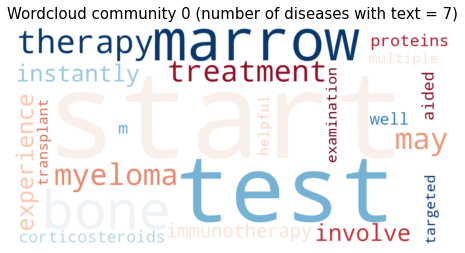

Number of diseases in community 0: 41


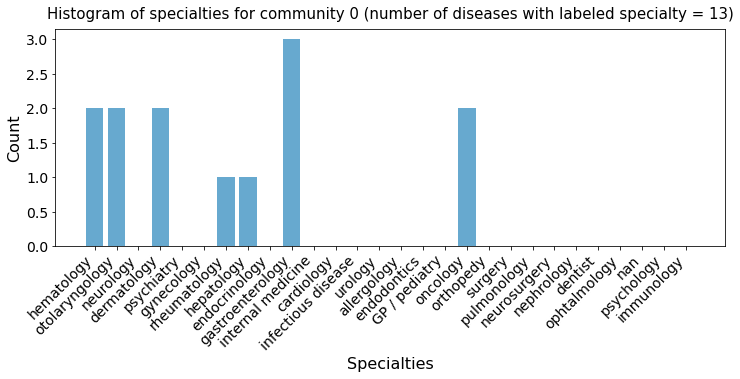

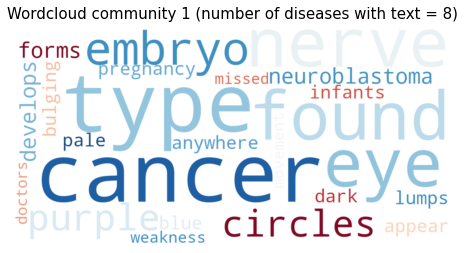

Number of diseases in community 1: 29


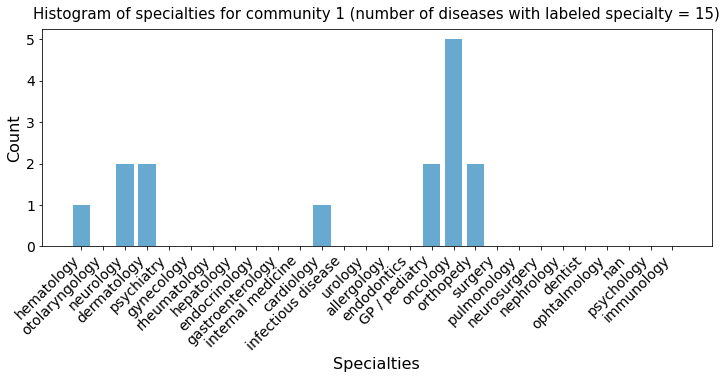

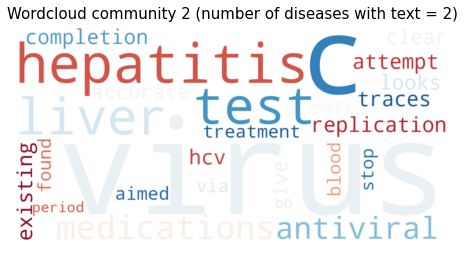

Number of diseases in community 2: 16


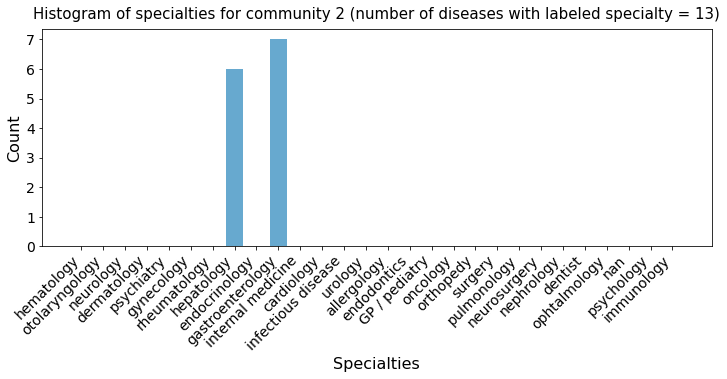

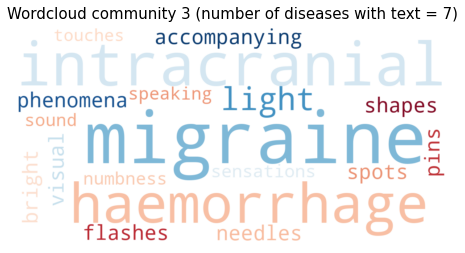

Number of diseases in community 3: 33


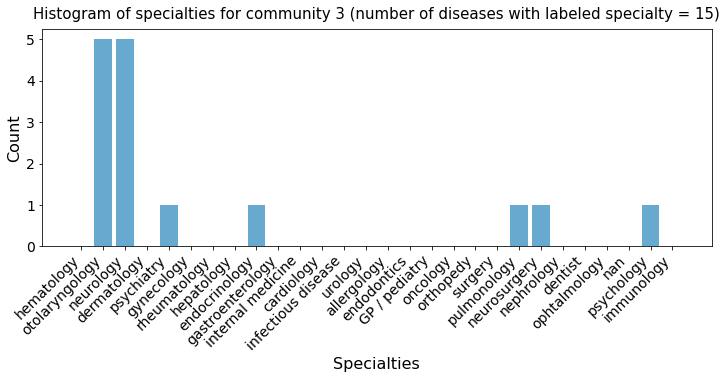

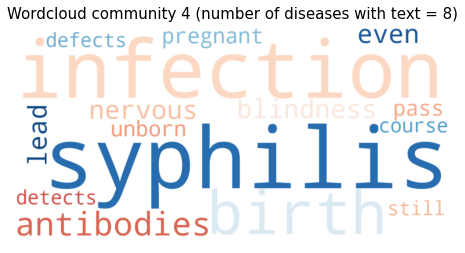

Number of diseases in community 4: 46


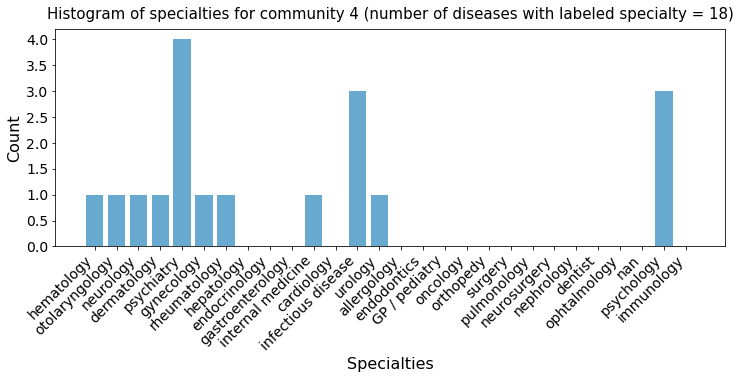

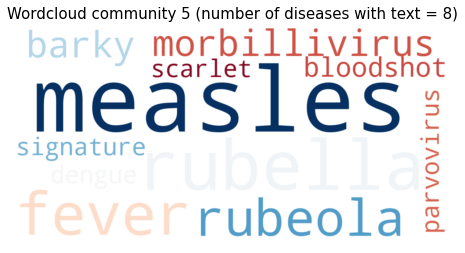

Number of diseases in community 5: 25


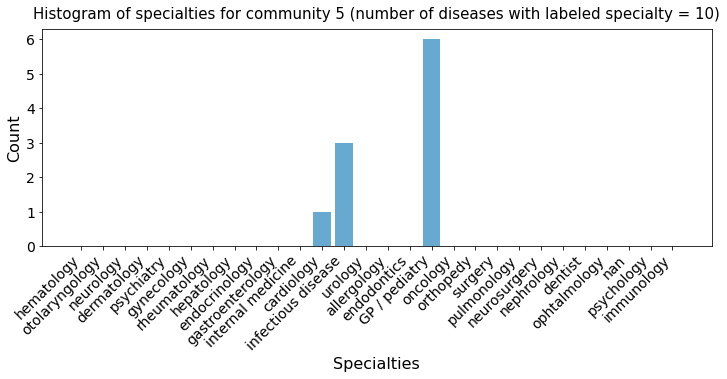

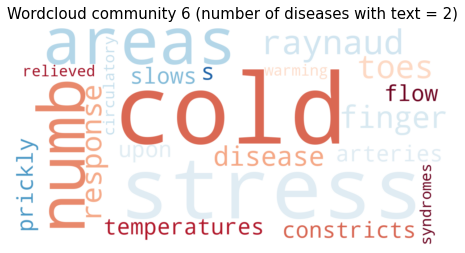

Number of diseases in community 6: 9


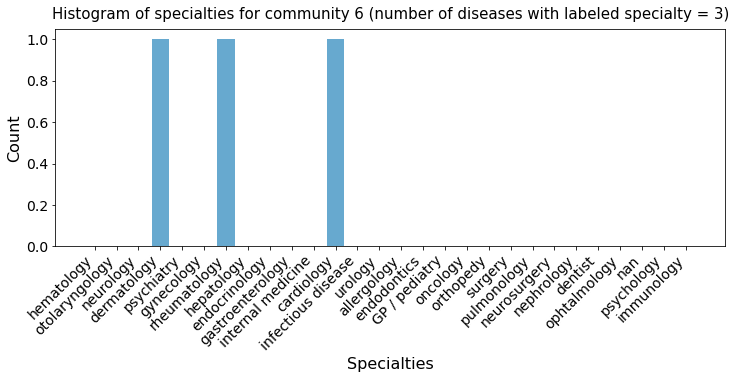

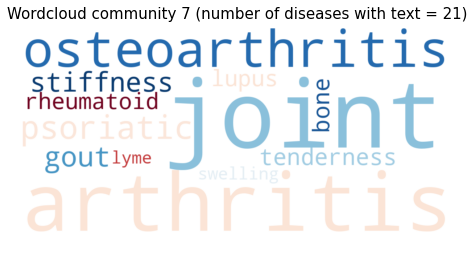

Number of diseases in community 7: 63


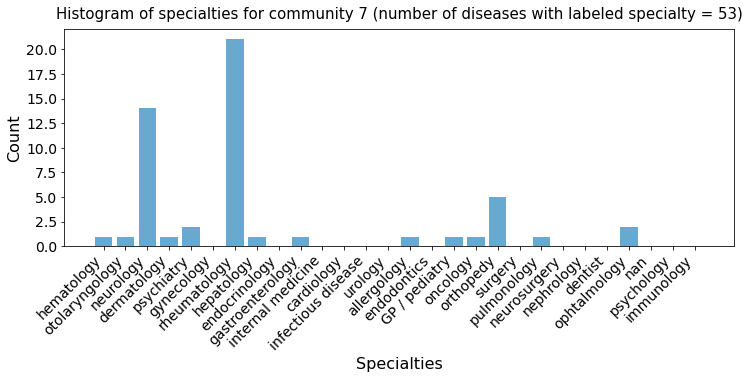

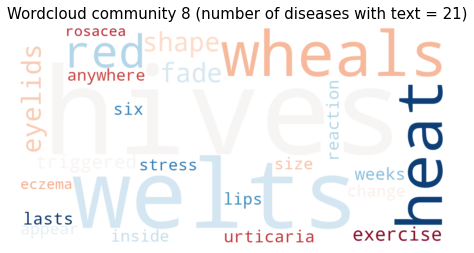

Number of diseases in community 8: 79


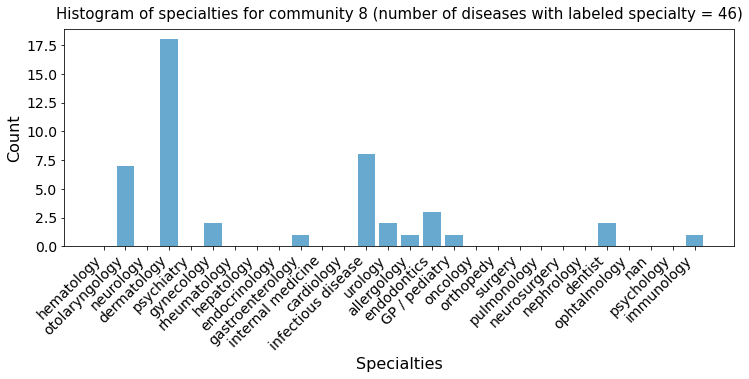

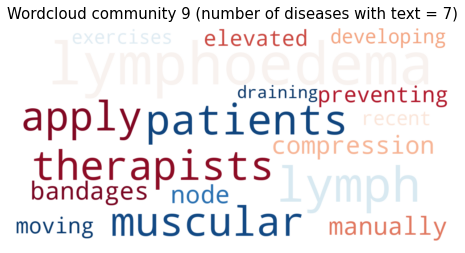

Number of diseases in community 9: 30


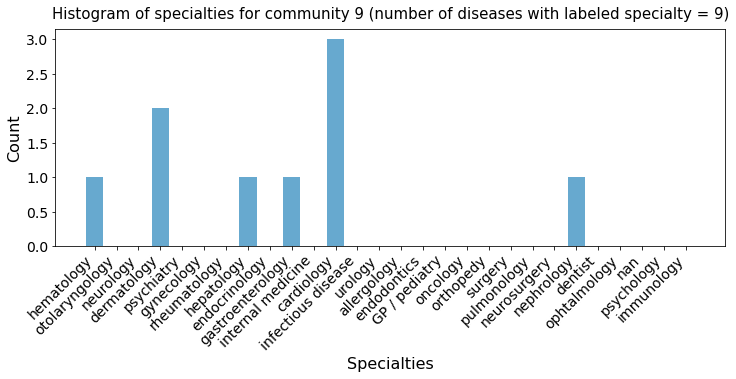

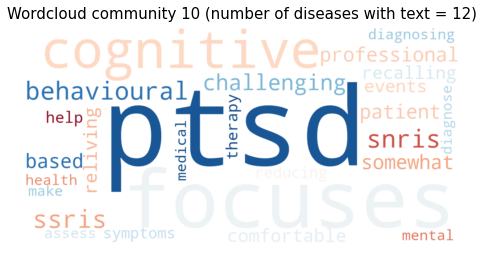

Number of diseases in community 10: 54


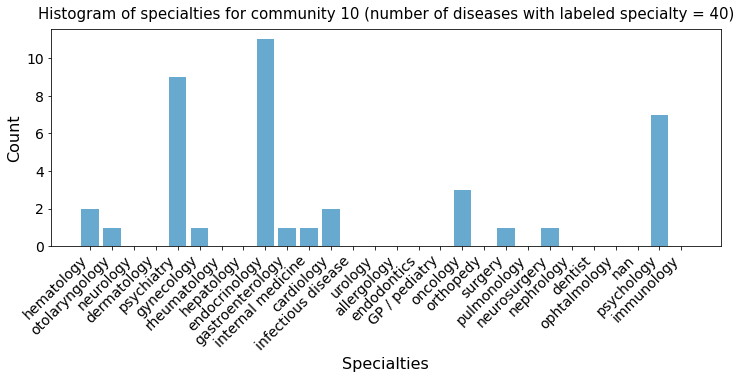

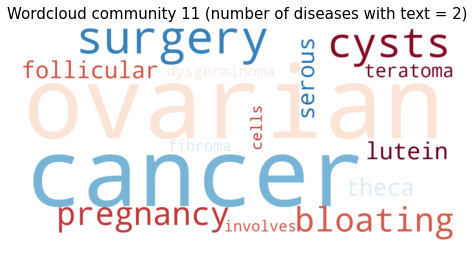

Number of diseases in community 11: 14


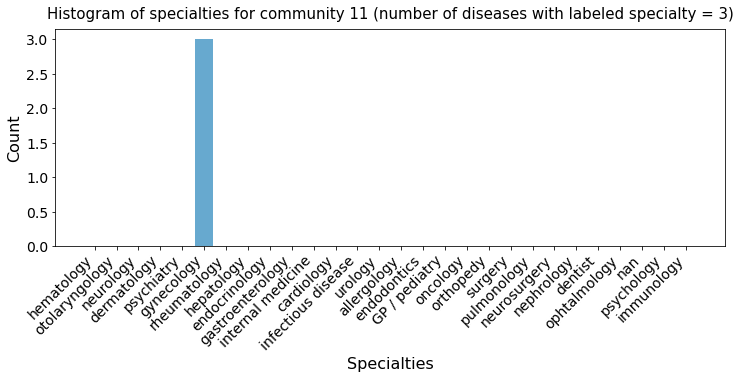

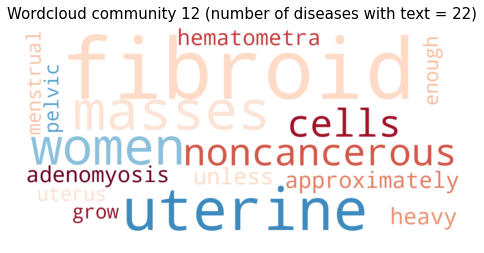

Number of diseases in community 12: 81


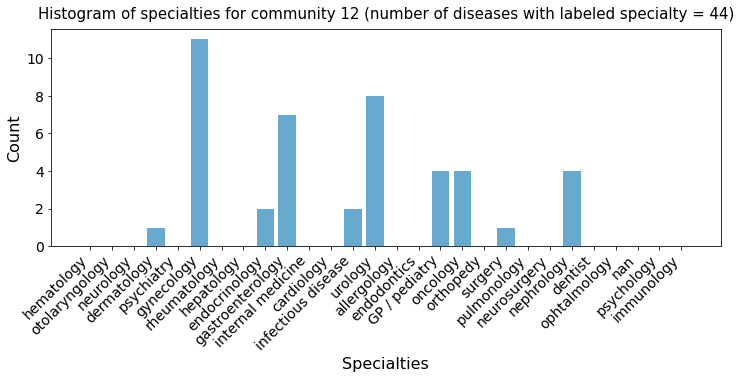

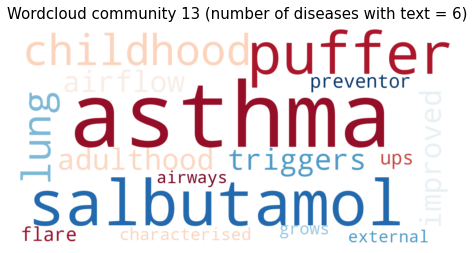

Number of diseases in community 13: 31


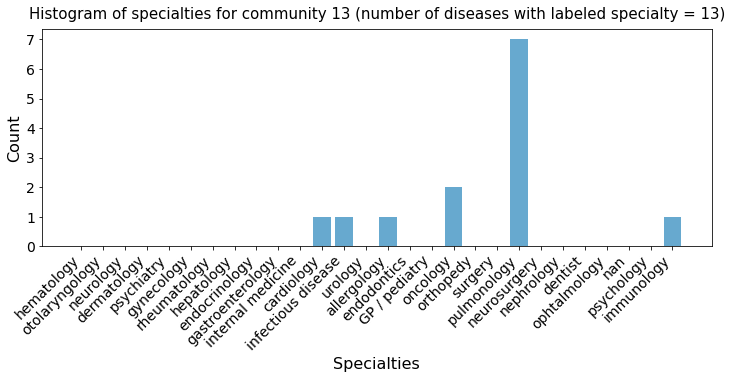

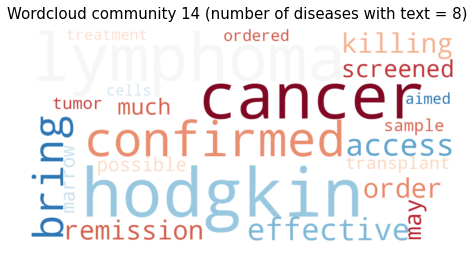

Number of diseases in community 14: 37


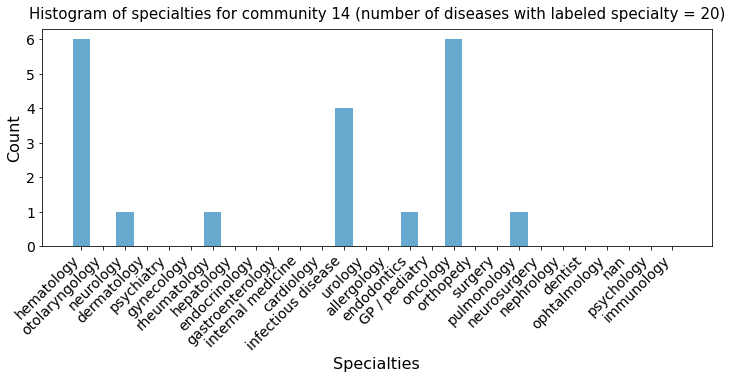

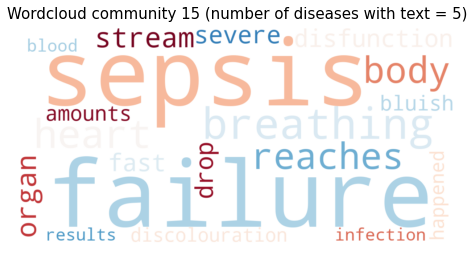

Number of diseases in community 15: 22


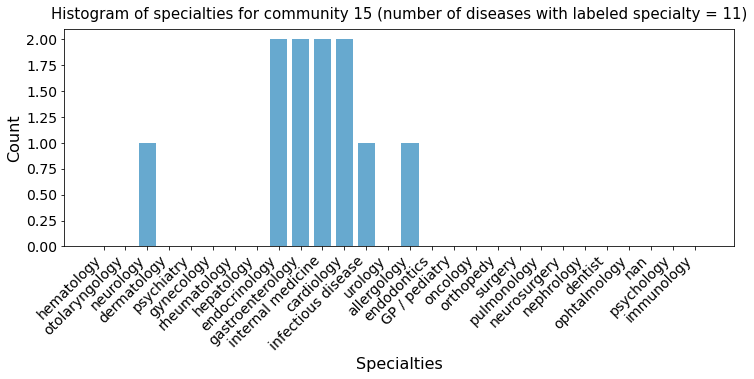

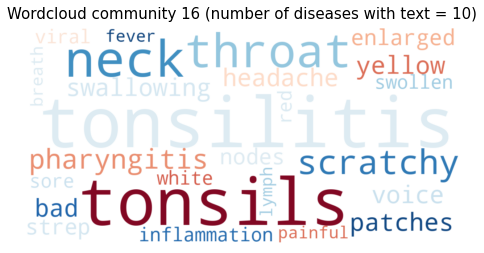

Number of diseases in community 16: 44


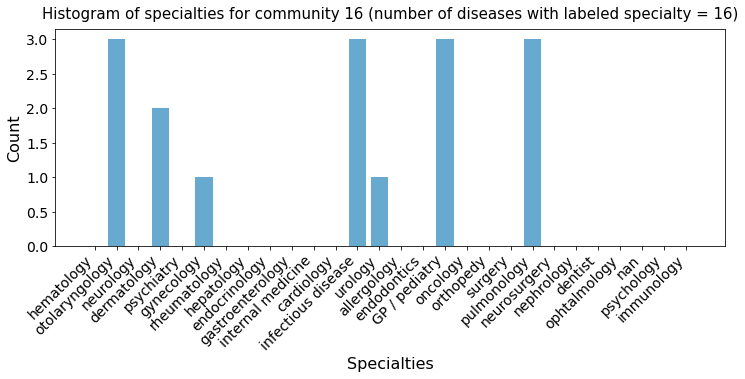

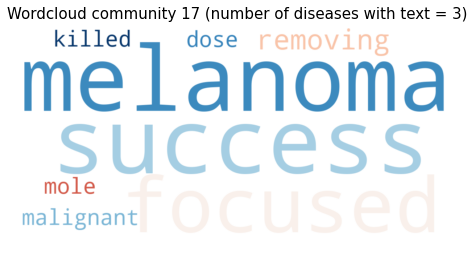

Number of diseases in community 17: 18


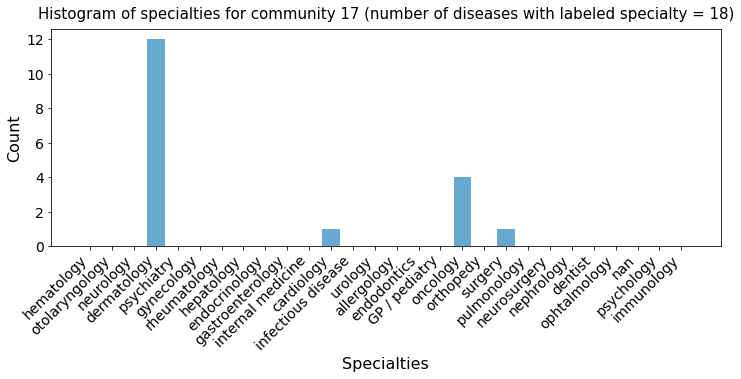

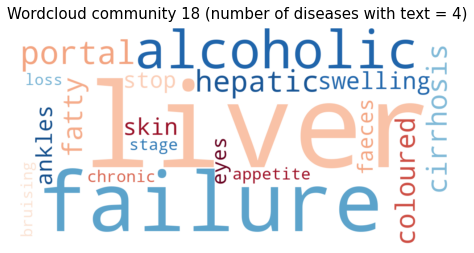

Number of diseases in community 18: 13


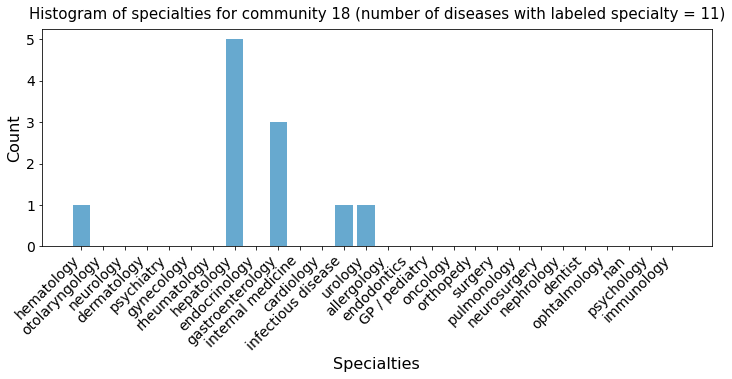

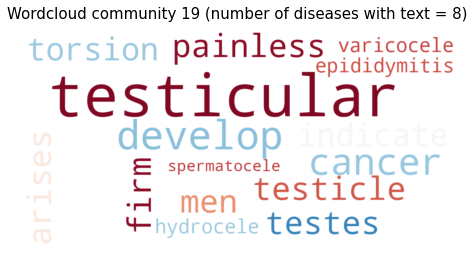

Number of diseases in community 19: 52


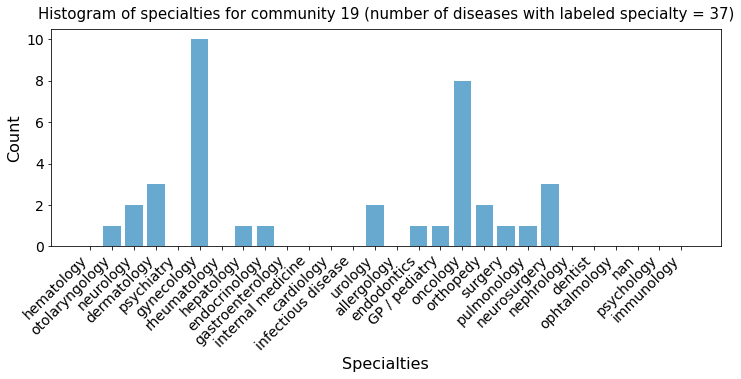

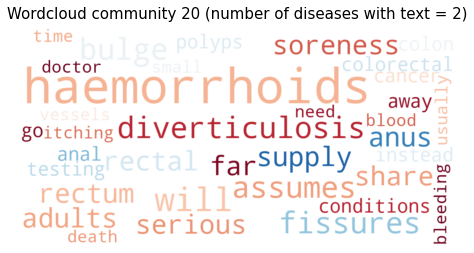

Number of diseases in community 20: 9


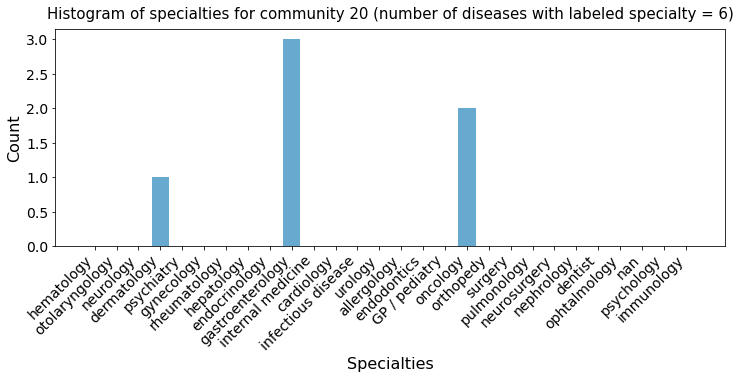

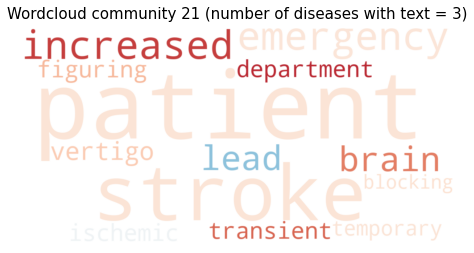

Number of diseases in community 21: 18


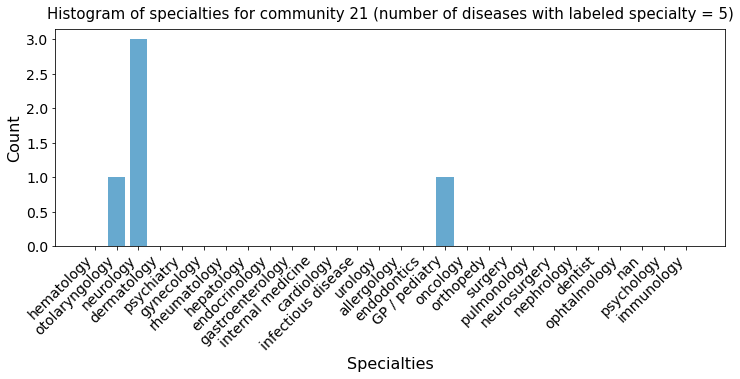

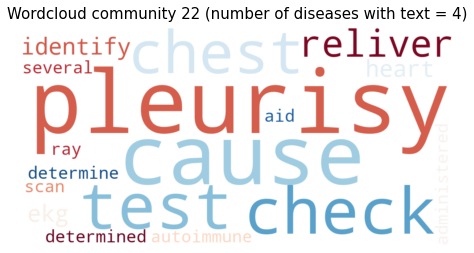

Number of diseases in community 22: 29


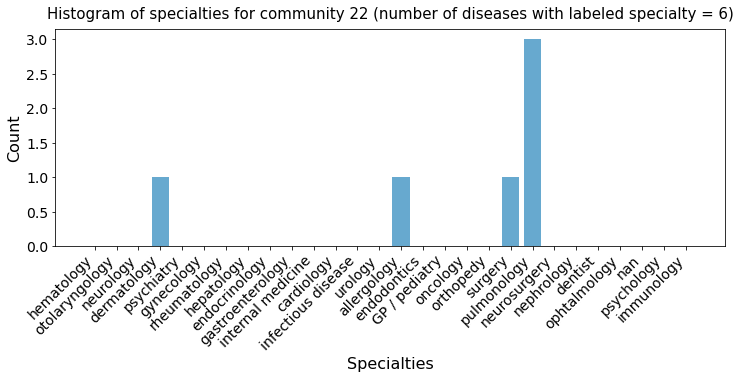

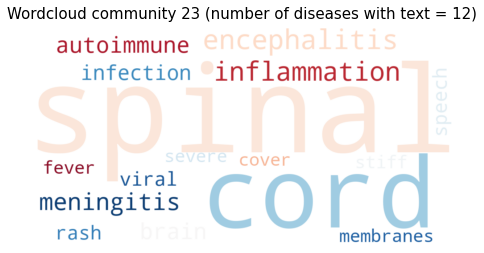

Number of diseases in community 23: 57


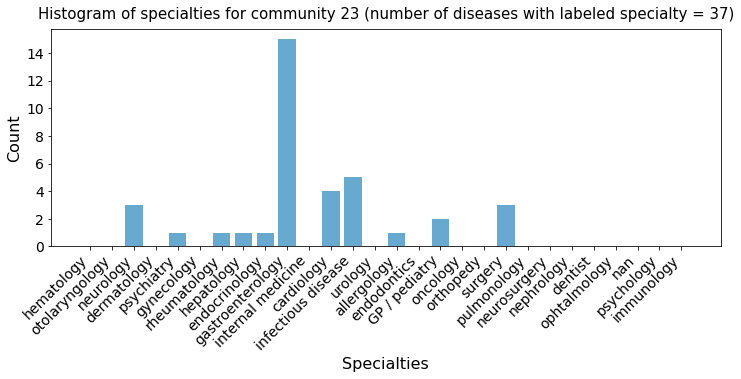

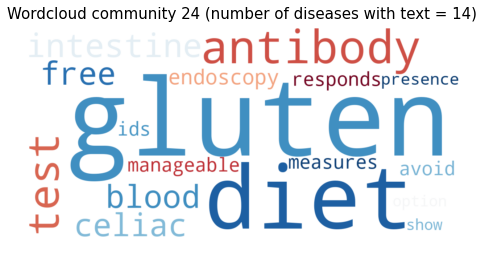

Number of diseases in community 24: 51


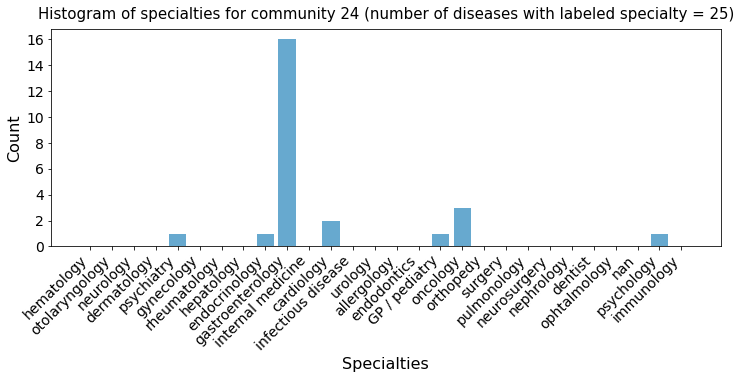

In [21]:
''' community analyzis '''

community_list = list()
community_starts = np.zeros(len(community_dict)+1)
community_diseases_with_text = np.zeros(len(community_dict))

for community_id, community_diseases in community_dict.items():
    # Group communities into single documents
    tokens_community, community_diseases_with_text[community_id] = aggregate_community(community_diseases, disease_text_dict)
    community_list = community_list + tokens_community
    community_starts[community_id+1] = int(community_starts[community_id] + len(tokens_community))

# Build IDF dict across the entire network
idf_dict = build_idf_dict(community_list)

# Calculate the TF-IDF for each of the communities
# and plot the corresponding wordcloud and histogram of specialties
specialty_list = (specialties_df['specialty 1'].append(specialties_df['specialty 2'])).unique()
for i, comm in enumerate(community_dict):
    tf_idf = get_community_tfidf(community_list[int(community_starts[i:i+1])], idf_dict)
    input_string = input_string_wordcloud(tf_idf)
    create_and_plot_wordcloud(input_string, comm, int(community_diseases_with_text[i]))
    plot_specialty_hist(G, i, community_dict[i], specialty_list)
    print('Number of diseases in community ' + str(i) + ': ' + str(len(community_dict[i])))